# Dask Diagnostic Tools

In this notebook we demonstrate a few diagnostic tools to examine the code excuation and performance. 

* Visualize task graphs
* Local diagnostics tools
* Distributed diagnostics tools
---

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Diagnostics
- Create Date: 2020-June
- Lineage/Reference: This tutorial is developed based on [Dask documentation](https://docs.dask.org/en/latest/understanding-performance.html).
---

### Prerequisite

The following modules are needed:

* Dask
* Bokeh

## Dask offer code profiling tools

The first step in making computations run quickly is to understand the costs involved. The Dask schedulers come with diagnostics to help you understand the performance characteristics of your computations. By using these diagnostics and with some thought, we can often identify the slow parts of troublesome computations.

### Visualize task graphs

In [ ]:
import dask.array as da
import graphviz
x = da.ones((15,15), chunks=(5,5))
y = x + x.T
y.visualize()

In [ ]:
z = x.dot(x.T + 1) - x.mean(axis=0)
z.visualize()

### Diagnostics (local)

`Dask.diagnostics` provides functionality to aid in profiling and inspecting execution with the local task scheduler.

This page describes the following few built-in options:

- ProgressBar
- Profiler
- ResourceProfiler
- CacheProfiler

#### Progress Bar

The `ProgressBar` class builds on the scheduler callbacks described above to display a progress bar in the terminal or notebook during computation. This can give a nice feedback during long running graph execution. It can be used as a context manager around calls to `get` or `compute` to profile the computation:

In [4]:
from dask.diagnostics import ProgressBar
a = da.random.normal(size=(10000, 10000), chunks=(1000, 1000))
res = a.dot(a.T).mean(axis=0)

with ProgressBar():
    out = res.compute()

[                                        ] | 0% Completed |  0.1s

/anaconda3/lib/python3.7/site-packages/dask/array/routines.py:239: PerformanceWarning: Increasing number of chunks by factor of 10
  axes=(left_axes, right_axes))


[########################################] | 100% Completed | 19.6s


or registered globally using the `register` method:

In [5]:
pbar = ProgressBar()
pbar.register()
out = res.compute()

[########################################] | 100% Completed | 19.6s


To unregister from the global callbacks, call the `unregister` method:

In [6]:
pbar.unregister()

#### Profiler - A profiler for task excution at task level

Dask provides a few tools for profiling execution. As with the `ProgressBar`, they each can be used as context managers or registered globally.

The `Profiler` class is used to profile Dask’s execution at the task level. During execution, it records the following information for each task:

1. Key
2. Task
3. Start time in seconds since the epoch
4. Finish time in seconds since the epoch
5. Worker id


#### ResourceProfiler - A profile for resource use

The `ResourceProfiler` class is used to profile Dask’s execution at the resource level. During execution, it records the following information for each timestep:

1. Time in seconds since the epoch
2. Memory usage in MB
3. % CPU usage

#### CacheProfiler - A profiler for dask execution at the scheduler cache level.

The `CacheProfiler` class is used to profile Dask’s execution at the scheduler cache level. During execution, it records the following information for each task:

1. Key
2. Task
3. Size metric
4. Cache entry time in seconds since the epoch
5. Cache exit time in seconds since the epoch

### Example

As an example to demonstrate using the diagnostics, we’ll profile some linear algebra done with Dask Array. We’ll create a random array, take its QR decomposition, and then reconstruct the initial array by multiplying the Q and R components together. Note that since the profilers (and all diagnostics) are just context managers, multiple profilers can be used in a with block:

In [14]:
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
a = da.random.random(size=(10000, 1000), chunks=(1000, 1000))
q, r = da.linalg.qr(a)
a2 = q.dot(r)

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    out = a2.compute()

In [ ]:
EnsNum=2
DS=[]
for i in range(1,EnsNum+1): #loop through ensemble members
    #concatenate data on time coordinate
    data=xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r'+str(i)+'i1p1f1/day/pr/gn/v*/pr_day_ACCESS-CM2_historical_r'+str(i)+'i1p1f1_gn_*.nc',combine='nested', concat_dim='time' )
    DS.append(data)
ds=xr.concat([DS[i] for i in range(EnsNum)],'ensemble')
pr_mean = ds['pr'].mean(dim='time')
spread = (pr_mean.max(dim='ensemble')
        - pr_mean.min(dim='ensemble'))

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
spread = spread.persist()

The results of each profiler are stored in their `results` attribute as a list of `namedtuple` objects:

In [15]:
prof.results[0]

TaskData(key=('random_sample-qr-e13da930fb68d042e516faef84fee342', 0, 0), task=(subgraph_callable, (<function _apply_random at 0x10da8cd90>, None, 'random_sample', array([2352970788, 1106497063, 1985962136,  567476613,  695996394,
       3277336804, 2816172410, 2576008344, 1256144496, 1407341517,
       4148684316,  662554608, 1020627637, 1332010898, 1606336784,
       1083588411, 1401081059, 1727811835, 2423538513,  816051187,
       3920780450, 1926128597, 2180290048, 1843335725, 2721202558,
         35981183, 1033091794, 2489108023, 4173760115, 1275431890,
       2216992865, 1066299213,  664668673, 4117611252, 2241620501,
       2728208303, 3886258932, 1879777596,  445709750, 2456039505,
       3564448120, 4087796328, 1143039758, 4276280980, 1820770161,
       4038931312, 4239518836,  868435338, 4033995970, 1319165279,
       1259761681, 4213504004, 2988178456, 4094259608, 3966210653,
       2975935965, 2458248388, 3813625304, 1518310746, 1614197992,
       1475138467,  246377294,  

In [16]:
rprof.results[0]

ResourceData(time=1633.931133371, mem=259.330048, cpu=0.0)

In [17]:
cprof.results[0]

CacheData(key=('random_sample-qr-e13da930fb68d042e516faef84fee342', 3, 0), task=(subgraph_callable, (<function _apply_random at 0x10da8cd90>, None, 'random_sample', array([4176503746, 1699941622, 2565477107, 3099543627, 1572395310,
       3708003615, 3187202975,  942891745, 4286064925, 3838466039,
       1456913696,   42737524, 3039175080, 3947846617, 1715833610,
        833903820, 1071356007, 2363202930, 4266157280,  685572191,
        447666554, 1124511246, 3323798228, 1910864487, 1548026100,
        870167142,  631966415,   39222057, 2797187756, 2015861294,
        617589821,  960498947, 4231639365,  433136232, 2620848739,
       3176108931, 1101585023,  690493466, 2454148260, 1473786954,
       2083582098,  618193632, 2245141561, 3964212234, 3847755882,
       1787842616, 3416930972, 1926207738, 2421534791, 3748341231,
       1398063168, 1783226888, 3445768866, 3071540976, 1497134927,
       1100563066, 3291449361, 4006170652,  775109587, 1236650384,
       3281466446, 3329537769, 

These can be analyzed separately or viewed in a bokeh plot using the provided `visualize` method on each profiler:

In [18]:
prof.visualize()

Figure(id='1002', ...)

To view multiple profilers at the same time, the `dask.diagnostics.visualize` function can be used. This takes a list of profilers and creates a vertical stack of plots aligned along the x-axis:

In [19]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='1375', ...)

Looking at the above figure, from top to bottom:

1. The results from the `Profiler` object: This shows the execution time for each task as a rectangle, organized along the y-axis by worker (in this case threads). Similar tasks are grouped by color and, by hovering over each task, one can see the key and task that each block represents.

2. The results from the `ResourceProfiler` object: This shows two lines, one for total CPU percentage used by all the workers, and one for total memory usage.

3. The results from the `CacheProfiler` object: This shows a line for each task group, plotting the sum of the current `metric` in the cache against time. In this case it’s the default metric (count) and the lines represent the number of each object in the cache at time. Note that the grouping and coloring is the same as for the `Profiler` plot, and that the task represented by each line can be found by hovering over the line.

From these plots we can see that the initial tasks (calls to `numpy.random.random` and `numpy.linalg.qr` for each chunk) are run concurrently, but only use slightly more than 100% CPU. This is because the call to `numpy.linalg.qr` currently doesn’t release the Global Interpreter Lock (GIL), so those calls can’t truly be done in parallel. Next, there’s a reduction step where all the blocks are combined. This requires all the results from the first step to be held in memory, as shown by the increased number of results in the cache, and increase in memory usage. Immediately after this task ends, the number of elements in the cache decreases, showing that they were only needed for this step. Finally, there’s an interleaved set of calls to `dot` and `sum`. Looking at the CPU plot, it shows that these run both concurrently and in parallel, as the CPU percentage spikes up to around 350%.

### Diagnostics (distributed)

The Dask distributed scheduler provides live feedback in two forms:

1. An interactive dashboard containing many plots and tables with live information
2. A progress bar suitable for interactive use in consoles or notebooks

If Bokeh is installed then the dashboard will start up automatically whenever the scheduler is created. For local use this happens when you create a client with no arguments:

In [21]:
from dask.distributed import Client
client = Client()

It is typically served at http://localhost:8787/status , but may be served elsewhere if this port is taken. The address of the dashboard will be displayed if you are in a Jupyter Notebook, or can be queried from `client.scheduler_info()['services']`.

You can watch the youtube video below to get a full overview of what dashboard offers. There are a number of pages with information about task runtimes, communication, statistical profiling, load balancing, memory use, and much more. 

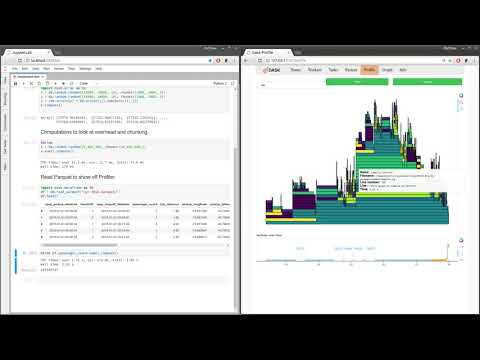

In [33]:
from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

display_yotube_video("https://www.youtube.com/watch?v=N_GqzcuGLCY", width=600, height=400)


You can capture some of the same information that the dashboard presents for offline processing using the `get_task_stream` and `Client.profile` functions. These capture the start and stop time of every task and transfer, as well as the results of a statistical profiler.

In [34]:
import dask.distributed
with get_task_stream(plot='save', filename="task-stream.html") as ts:
    x.compute()

client.profile(filename="dask-profile.html")

history = ts.data

NameError: name 'get_task_stream' is not defined

Get back a Bokeh figure and optionally save to a file

In [ ]:
with get_task_stream(plot='save', filename='task-stream.html') as ts:
    x.compute()
    ts.figure

Additionally, Dask can save many diagnostics dashboards at once including the task stream, worker profiles, bandwidths, etc. with the `performance_report` context manager:

In [ ]:
from dask.distributed import performance_report

with performance_report(filename="dask-report.html"):
    ## some dask computation

### Progress bar

The `dask.distributed` progress bar differs from the `ProgressBar` used for local diagnostics. The `progress` function takes a Dask object that is executing in the background:

In [20]:
# Single machine progress bar
from dask.diagnostics import ProgressBar

with ProgressBar():
    x.compute()

# Distributed scheduler ProgressBar

from dask.distributed import Client, progress

client = Client()  # use dask.distributed by default

x = x.persist()  # start computation in the background
progress(x)      # watch progress

x.compute()      # convert to final result when done if desired

[########################################] | 100% Completed |  0.1s


/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/anaconda3/lib/python3.7/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

### The accessible port

The default port for the web interface is 8787. However, some clusters restrict the ports that are visible to the outside world. These ports may include the default port for the web interface, 8787. There are a few ways to handle this:

1. Open port `8787` to the outside world. Often this involves asking your cluster administrator.
2. Use a different port that is publicly accessible using the --`dashboard-address :8787` option on the `dask-scheduler` command.
3. Use fancier techniques, like Port Forwarding

If you create distributed schedular from Pangeo environment on Gadi, a random port number (8000-8999) for the dashboard will be assigned to you. See more information on page about [setting up Pangeo environment on Gadi]().

### Summary

This example shows some dask diagnostic tools to examine the runtime and resource usages. 